In [1]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
from scipy.sparse import diags

import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font to Times New Roman for the whole plot
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'

## Functions

In [2]:
# Optimal controls verification
def optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y,
                     delta_a_2,delta_b_2):
    
    K=k_matrix(N_1, lambda_a, lambda_b, phi1, kappa1, Y_1, hat_y1, delta_a_2, delta_b_2)
    w=W_t_function(alpha1, kappa1, zeta, Y_1, hat_y1, K, t)
    
    
    h1_1st=h1_function(zeta,kappa1,w,y,Y_1);
    h1_2nd=h1_function(zeta,kappa1,w,y+zeta,Y_1);
    h1_3rd=h1_function(zeta,kappa1,w,y-zeta,Y_1);
    z= m2_1/(y**2);
    delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta
    delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta
    return delta_b_star, delta_a_star

In [3]:
#level functions and derivative
def lvlfct(m_2, y):
    return m_2/y;

def lvlfct_deriv(m_2,y):
    return -m_2/y**2

In [4]:
# h1 and H1
def h1_function(zeta, kappa, w, y, Y_1):
    # Find entries in w where Y_1 matches y
    w=np.sqrt(w)
    matched_w = w[Y_1 == y]
    # Check if the matched_w array is empty
    if matched_w.size == 0:
        return np.nan  # Return np.nan if y is not found in Y_1
    else:
        # Calculate h1 if there is at least one match
        h1 = (zeta / kappa) * np.log(matched_w.item())  # Assuming only one match; use matched_w[0] if multiple matches are handled differently
        return h1
    
def H1_function(x,y,z,h1):
    H1=x+y*z+h1
    return H1

In [5]:
#W_t
def W_t_function(alpha1, kappa1, zeta, Y_1, hat_y1, K, t):
    exponent_values = -alpha1 * kappa1 / zeta * (Y_1 - hat_y1)**2
    W0 = (np.exp(exponent_values)) **2
    W_t = expm(K * (T-t)).dot(W0)
    return W_t

In [6]:
def k_matrix(N_1, lambda_a, lambda_b, phi1, kappa1, Y_1, hat_y1, delta_a_2, delta_b_2):
    # The main diagonal values
    main_diag = -2 * kappa1 * phi1 * (Y_1 - hat_y1)**2 / zeta

    # Subdiagonal and superdiagonal values
    sub_diag = lambda_a * np.exp(kappa1 * delta_a_2 - 1) * np.ones(N_1)  
    super_diag = lambda_b * np.exp(kappa1 * delta_b_2 - 1) * np.ones(N_1)

    # Create the tridiagonal sparse matrix
    diagonals = [sub_diag, main_diag, super_diag]
    K = diags(diagonals, offsets=[-1, 0, 1], shape=(N_1+1, N_1+1), format='csr')
    
    return K.todense()

## Parameters and initial assumptions

In [7]:
# AMM settings and Perfparameters
zeta = 1
T = 30 #seconds
lambda_a = 1
lambda_b = 1

In [8]:
# LP1 reserves and settings
x0_1=1; #60kUSDC
y0_1=1; #20ETH
z0_1=x0_1/y0_1; #initial marginal rate
m2_1=x0_1*y0_1;

y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)
Z_1 = m2_1 / (Y_1 ** 2 + 1e-10)  # Adding a small constant to avoid division by zero

phi1 = 10**(-5) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 2 #objective y

In [9]:
# LP2 reserves and settings
delta_a_2=0.0001;
delta_b_2=0.0001;

## Proposition 1

### Testing

In [10]:
t=1
delta_b_star, delta_a_star = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y0_1,
                     delta_a_2,delta_b_2)
print(f"Optimal delta_b_star: {delta_b_star}")
print(f"Optimal delta_a_star: {delta_a_star}")

Optimal delta_b_star: 0.06317024632170883
Optimal delta_a_star: 0.0463302504670637


In [11]:
K=k_matrix(N_1, lambda_a, lambda_b, phi1, kappa1, Y_1, hat_y1, delta_a_2, delta_b_2)

In [12]:
w=W_t_function(alpha1, kappa1, zeta, Y_1, hat_y1, K, t);
w

array([1.53971688e+08, 2.83917069e+08, 3.69476490e+08, 3.97614166e+08,
       3.64781635e+08, 2.77165914e+08, 1.49083153e+08])

In [13]:
z= m2_1/(y0_1**2);
z

1.0

In [14]:
h1_1st=h1_function(zeta,kappa1,w,y0_1,Y_1);
print(h1_1st)

0.9863798835247007


In [15]:
h1_2nd=h1_function(zeta,kappa1,w,y0_1+zeta,Y_1);
print(h1_2nd)

0.9732096372029919


In [16]:
h1_3rd=h1_function(zeta,kappa1,w,y0_1-zeta,Y_1);
print(h1_3rd)

0.990049633057637


In [17]:
delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta
delta_b_star

0.06317024632170883

In [18]:
delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta
delta_a_star

0.0463302504670637

### Simulations

### Simulating for non-competitive LP2: S=Z, different y values with Z constant, y_hat=0
We will compare how the depth of an LP would vary as he is far away from his objective

In [62]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-2) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.5;
delta_b_2=0.5;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_1 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_1 = np.zeros((len(y_test_range),len(t_grid)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_1[i,j], delta_a_star_1[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     delta_a_2,delta_b_2)

/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_21704/488826461.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_21704/488826461.py:17: RuntimeWarning: invalid value encountered in scalar subtract
  delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta


In [63]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi11 = np.linspace(10**(-1),10**(-2)) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.5;
delta_b_2=0.5;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[80]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_2 = np.zeros((len(y_test_range),len(phi11)))
delta_a_star_2 = np.zeros((len(y_test_range),len(phi11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, phi in enumerate(phi11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_2[i,j], delta_a_star_2[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     delta_a_2,delta_b_2)

In [64]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-2) # No inventory penalty
alpha11 = np.linspace(10**(-1),10**(-3)) # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.5;
delta_b_2=0.5;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[-10]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_3 = np.zeros((len(y_test_range),len(alpha11)))
delta_a_star_3 = np.zeros((len(y_test_range),len(alpha11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, alpha in enumerate(alpha11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_3[i,j], delta_a_star_3[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     delta_a_2,delta_b_2)

In [65]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-2) # No inventory penalty
alpha1 = 10**(-3) # No terminal penalty
kappa11= np.linspace(1,30)
hat_y1 = 0 #objective y

delta_a_2=0.5;
delta_b_2=0.5;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[10]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_4 = np.zeros((len(y_test_range),len(kappa11)))
delta_a_star_4 = np.zeros((len(y_test_range),len(kappa11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, kappa in enumerate(kappa11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_4[i,j], delta_a_star_4[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa,
                     Y_1,hat_y1,m2_1,y_test,
                     delta_a_2,delta_b_2)

/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_21704/488826461.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_21704/488826461.py:17: RuntimeWarning: invalid value encountered in scalar subtract
  delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta


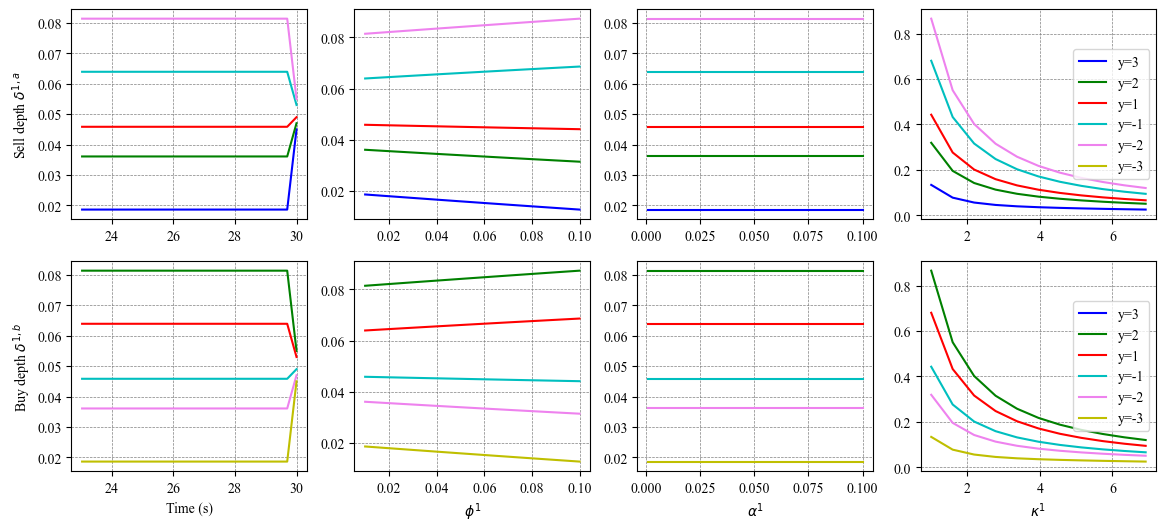

In [66]:
plt.figure(figsize=(14,6))


plt.subplot(2,4,1)
plt.plot(t_grid,delta_a_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_a_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_a_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_a_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_a_star_1[1,:],'violet',label='y=-2')
plt.plot(t_grid,delta_a_star_1[0,:],'y',label='y=-3')
plt.ylabel('Sell depth $\delta^{1,a}$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,5)
plt.plot(t_grid,delta_b_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_1[1,:],'violet',label='y=-2')
plt.plot(t_grid,delta_b_star_1[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel('Buy depth $\delta^{1,b}$');
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,2)
plt.plot(phi11,delta_a_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_a_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_a_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_a_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_a_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_a_star_2[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,6)
plt.plot(phi11,delta_b_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_b_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_b_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_b_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_b_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_b_star_2[0,:],'y',label='y=-3')
plt.xlabel('$\\phi^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,3)
plt.plot(alpha11,delta_a_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_a_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_a_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_a_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_a_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_a_star_3[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,7)
plt.plot(alpha11,delta_b_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_b_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_b_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_b_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_b_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_b_star_3[0,:],'y',label='y=-3')
plt.xlabel('$\\alpha^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,4)
plt.plot(kappa11,delta_a_star_4[5,:],'b',label='y=3')
plt.plot(kappa11,delta_a_star_4[4,:],'g',label='y=2')
plt.plot(kappa11,delta_a_star_4[3,:],'r',label='y=1')
plt.plot(kappa11,delta_a_star_4[2,:],'c',label='y=-1')
plt.plot(kappa11,delta_a_star_4[1,:],'violet',label='y=-2')
plt.plot(kappa11,delta_a_star_4[0,:],'y',label='y=-3')
plt.legend(loc='center right')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,8)
plt.plot(kappa11,delta_b_star_4[5,:],'b',label='y=3')
plt.plot(kappa11,delta_b_star_4[4,:],'g',label='y=2')
plt.plot(kappa11,delta_b_star_4[3,:],'r',label='y=1')
plt.plot(kappa11,delta_b_star_4[2,:],'c',label='y=-1')
plt.plot(kappa11,delta_b_star_4[1,:],'violet',label='y=-2')
plt.plot(kappa11,delta_b_star_4[0,:],'y',label='y=-3')
plt.legend(loc='center right')
plt.xlabel('$\\kappa^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

# If you need to set ticks in Times New Roman, ensure this by setting tick labels explicitly if needed
# Example to set x-ticks (similarly for y-ticks):
plt.xticks(fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
plt.savefig('General analysis Model 1.b.png', format='png', dpi=300, bbox_inches='tight')

We can see that as y_hat is the objective against which there is a terminal and inventory penalty, the MM wants to reach 0. The figure shows the behaviour of the optimal depths as a function of time for different inventory levels. In the examples, the arrival rate of MOs is lambda a=lambda b=1 (i.e., there are on average 1 buy and 1 sell MO per second), max y=-min y =3, and phi=10^-5. On the left, we show the optimal sell postings delta^a, i.e., upon the arrival of a market buy order the MM is willing to sell one unit of the asset at the price S_t +delta^a, and in the right, we show the optimal buy postings delta^a. For example, when the strategy is away from expiry (T=30 seconds) and inventories are closed to allowed minimum (e.g., y=-2), the optimal sell postings is further away from the midprice (delta^a=0.081) bcs only at a very high price is the LP willing to decrease the inventory further, and at the same time the optimal buy is close to the midprice (delta^b=0.037) bcs the LP would like to complete round-trip trades (i.e., a buy followed by a sell or a sell followed by a buy) and push inventories to zeros. TRY CHANGING y_hat

We also observe that as the strategy approaches T and y<0 (e.g.,y=-2), the optimal sell decreases (delta^a: from 0.081 to 0.055) and the optimal buy increases (delta^b: from 0.037 to 0.046). To understand this, not that if the terminal inventory y<0 is liquidated, then when the terminal penalty alpha is very small as well as being fractions of seconds away of T, it is optimal to post nearer the midprice to increase the chances of being filled (i.e., selling one more unit of the asset) because the price is not expected to move too much before expiry and the entire position will be unwound at the midprice - making a profit on the last asset that was sold.

In [ ]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-5) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=np.linspace(0,0.2);
delta_b_2=np.linspace(0,0.2);

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[-5]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star = np.zeros((len(y_test_range),len(delta_a_2)))
delta_a_star = np.zeros((len(y_test_range),len(delta_a_2)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j in range(len(delta_a_2)):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        
        delta_b_star[i,j], delta_a_star[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     delta_a_2[j],delta_b_2[j])

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(delta_a_2,delta_a_star[5,:],'b',label='y=3')
plt.plot(delta_a_2,delta_a_star[4,:],'g',label='y=2')
plt.plot(delta_a_2,delta_a_star[3,:],'r',label='y=1')
plt.plot(delta_a_2,delta_a_star[2,:],'c',label='y=-1')
plt.plot(delta_a_2,delta_a_star[1,:],'violet',label='y=-2')
plt.plot(delta_a_2,delta_a_star[0,:],'y',label='y=-3')
plt.legend()
plt.xlabel('Competitor sell depth $\delta^{2,a}$')
plt.ylabel('Sell depth $\delta^{1,a}$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(delta_b_2,delta_b_star[5,:],'b',label='y=3')
plt.plot(delta_b_2,delta_b_star[4,:],'g',label='y=2')
plt.plot(delta_b_2,delta_b_star[3,:],'r',label='y=1')
plt.plot(delta_b_2,delta_b_star[2,:],'c',label='y=-1')
plt.plot(delta_b_2,delta_b_star[1,:],'violet',label='y=-2')
plt.plot(delta_b_2,delta_b_star[0,:],'y',label='y=-3')
plt.legend()
plt.xlabel('Competitor buy depth $\delta^{2,b}$')
plt.ylabel('Buy depth $\delta^{1,b}$');
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.savefig('Varying competing depth Model 1.b.png', format='png', dpi=300, bbox_inches='tight')

### Simulating for non-competitive LP2: S cheaper that Z, different y values with Z constant, y_hat=0
We will compare how the depth of an LP would vary as he is far away from his objective

### Simulating for non-competitive LP2: S more expensive that Z, different y values with Z constant, y_hat=0
We will compare how the depth of an LP would vary as he is far away from his objective

### Simulating for competitive LP2: S=Z1=Z2, different y values with Z constant, y_hat=0
We will compare how the depth of an LP would vary as he is far away from his objective

In [ ]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-2) # No inventory penalty
alpha1 = 10**(-1) # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.01;
delta_b_2=0.01;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_1 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_1 = np.zeros((len(y_test_range),len(t_grid)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        
        delta_b_star_1[i,j], delta_a_star_1[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     delta_a_2,delta_b_2)

In [ ]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi11 = np.linspace(10**(-1),10**(-2)) # No inventory penalty
alpha1 = 0.1 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.01;
delta_b_2=0.01;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[-1]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_2 = np.zeros((len(y_test_range),len(phi11)))
delta_a_star_2 = np.zeros((len(y_test_range),len(phi11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, phi in enumerate(phi11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        
        delta_b_star_2[i,j], delta_a_star_2[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     delta_a_2,delta_b_2)

In [ ]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-2) # No inventory penalty
alpha11 = np.linspace(10**(-0),10**(-1)) # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.01;
delta_b_2=0.01;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[-1]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_3 = np.zeros((len(y_test_range),len(alpha11)))
delta_a_star_3 = np.zeros((len(y_test_range),len(alpha11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, alpha in enumerate(alpha11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        
        delta_b_star_3[i,j], delta_a_star_3[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     delta_a_2,delta_b_2)

In [ ]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-2) # No inventory penalty
alpha1 = 10**(-1) # No terminal penalty
kappa11= np.linspace(1,30)
hat_y1 = 0 #objective y

delta_a_2=0.01;
delta_b_2=0.01;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[-1]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_4 = np.zeros((len(y_test_range),len(kappa11)))
delta_a_star_4 = np.zeros((len(y_test_range),len(kappa11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, kappa in enumerate(kappa11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        
        delta_b_star_4[i,j], delta_a_star_4[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa,
                     Y_1,hat_y1,m2_1,y_test,
                     delta_a_2,delta_b_2)

In [ ]:
plt.figure(figsize=(14,6))


plt.subplot(2,4,1)
plt.plot(t_grid,delta_a_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_a_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_a_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_a_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_a_star_1[1,:],'violet',label='y=-2')
plt.plot(t_grid,delta_a_star_1[0,:],'y',label='y=-3')
plt.ylabel('Sell depth $\delta^{1,a}$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,5)
plt.plot(t_grid,delta_b_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_1[1,:],'violet',label='y=-2')
plt.plot(t_grid,delta_b_star_1[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel('Buy depth $\delta^{1,b}$');
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,2)
plt.plot(phi11,delta_a_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_a_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_a_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_a_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_a_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_a_star_2[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,6)
plt.plot(phi11,delta_b_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_b_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_b_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_b_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_b_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_b_star_2[0,:],'y',label='y=-3')
plt.xlabel('$\\phi^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,3)
plt.plot(alpha11,delta_a_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_a_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_a_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_a_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_a_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_a_star_3[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,7)
plt.plot(alpha11,delta_b_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_b_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_b_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_b_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_b_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_b_star_3[0,:],'y',label='y=-3')
plt.xlabel('$\\alpha^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,4)
plt.plot(kappa11,delta_a_star_4[5,:],'b',label='y=3')
plt.plot(kappa11,delta_a_star_4[4,:],'g',label='y=2')
plt.plot(kappa11,delta_a_star_4[3,:],'r',label='y=1')
plt.plot(kappa11,delta_a_star_4[2,:],'c',label='y=-1')
plt.plot(kappa11,delta_a_star_4[1,:],'violet',label='y=-2')
plt.plot(kappa11,delta_a_star_4[0,:],'y',label='y=-3')
plt.legend(loc='center right')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,8)
plt.plot(kappa11,delta_b_star_4[5,:],'b',label='y=3')
plt.plot(kappa11,delta_b_star_4[4,:],'g',label='y=2')
plt.plot(kappa11,delta_b_star_4[3,:],'r',label='y=1')
plt.plot(kappa11,delta_b_star_4[2,:],'c',label='y=-1')
plt.plot(kappa11,delta_b_star_4[1,:],'violet',label='y=-2')
plt.plot(kappa11,delta_b_star_4[0,:],'y',label='y=-3')
plt.legend(loc='center right')
plt.xlabel('$\\kappa^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.savefig('General analysis Model 1.b with competing depths.png', format='png', dpi=300, bbox_inches='tight')